# Imports

In [1]:
#Imports
%matplotlib widget
import pandas as pd
import numpy as np
import csv
import matplotlib
import matplotlib.pyplot as plt
import scipy
import datetime
import networkx as nx
import misc
import math
import random
import SmallBucket
import BigBucket
import RandomWarmUp1
import RandomWarmUp2
import StaticDynamic
import DcOrient

# Data Generation

In [2]:
G = misc.createRandomGraph(size=30, variation=0, prioritized=True)
misc.graphInfo(G)

avg = misc.getAverageDegree(G)
variance = 0
degreeTuples = list(G.degree(list(G.nodes())))

for tuple in degreeTuples:
    variance += abs(avg - tuple[1])

variance = float(variance) / G.number_of_nodes()

variance

Nodes: 30
Edges: 217
Density: 0.49885057471264366
Max Degree: 20
Average Degree: 14.466666666666667
Static Coloring uses 8 colors


2.524444444444445

In [3]:
updates = misc.extractUpdates(G, 'shuffled')

In [4]:
updates

[(0, 20),
 (0, 5),
 (0, 13),
 (11, 16),
 (18, 22),
 (5, 24),
 (0, 19),
 (15, 18),
 (16, 29),
 (0, 10),
 (17, 27),
 (0, 21),
 (5, 21),
 (6, 23),
 (7, 21),
 (1, 6),
 (1, 27),
 (27, 29),
 (1, 9),
 (10, 23),
 (1, 10),
 (1, 12),
 (7, 27),
 (14, 18),
 (5, 27),
 (1, 17),
 (13, 23),
 (9, 10),
 (8, 24),
 (2, 4),
 (2, 18),
 (9, 19),
 (3, 4),
 (0, 25),
 (19, 24),
 (2, 26),
 (2, 19),
 (21, 28),
 (10, 18),
 (15, 26),
 (6, 26),
 (23, 27),
 (7, 12),
 (3, 22),
 (12, 16),
 (3, 6),
 (3, 17),
 (2, 13),
 (4, 15),
 (12, 15),
 (4, 6),
 (4, 5),
 (4, 20),
 (4, 9),
 (4, 19),
 (4, 7),
 (8, 23),
 (5, 15),
 (4, 11),
 (4, 29),
 (24, 27),
 (6, 16),
 (4, 12),
 (6, 18),
 (1, 2),
 (5, 28),
 (17, 19),
 (5, 17),
 (5, 18),
 (16, 20),
 (19, 28),
 (6, 22),
 (5, 6),
 (2, 11),
 (3, 7),
 (16, 26),
 (16, 19),
 (5, 12),
 (0, 15),
 (3, 14),
 (9, 26),
 (2, 21),
 (11, 12),
 (3, 15),
 (0, 12),
 (6, 17),
 (5, 8),
 (20, 21),
 (18, 23),
 (14, 29),
 (6, 27),
 (5, 9),
 (2, 29),
 (6, 29),
 (7, 24),
 (7, 10),
 (7, 13),
 (20, 22),
 (7, 16)

In [4]:
Ge = nx.Graph()
Ge.add_nodes_from(list(G.nodes()))

# Algorithm Preparation

In [5]:
experimentList = []

experimentList.append((SmallBucket.SmallBucketAlgo(5, Ge), 'Small-Bucket algorithm with d = 5'))
experimentList.append((BigBucket.BigBucketAlgo(5, Ge), 'Big-Bucket algorithm with d = 5'))
experimentList.append((StaticDynamic.StaticDynamicAlgo(Ge, 5, dynamicReset=False), 'Static-Dynamic algorithm with l = 5'))
experimentList.append((RandomWarmUp1.WarmUp1Algo(Ge, maxDegreeBound=None), 'Random Warm-Up 1 without max degree'))
experimentList.append((RandomWarmUp2.WarmUp2Algo(Ge, maxDegreeBound=None), 'Random Warm-Up 2 without max degree'))
experimentList.append((DcOrient.DcOrientAlgo(Ge), 'DC-Orient'))

# Experimenting

In [6]:
print('Graph used in the experiment:')
misc.graphInfo(G)

for experiment in experimentList:

    print("")
    print("------------------------------------------------------------------")
    print(str(experiment[1]) + ":")
    iterator = misc.UpdateIterator(experiment[0], updates)

    recolors = 0

    while True:
        if not misc.verifyColoring(iterator.algo.G, iterator.algo.getColoring()):
            raise ValueError('The coloring produced is incorrect')
        c1 = iterator.algo.getColoring()
        if iterator.runUpdate(1):
            c2 = iterator.algo.getColoring()
            recolors += misc.numberOfRecolors(c1, c2)
        else:
            #print("all updates finished")
            break

    print("")
    print("Average number of recolors per update: " + str(float(recolors)/len(updates)))
    print("Total number of colors used at the end: " + str(misc.numberOfColors(iterator.algo.getColoring())))
    print("------------------------------------------------------------------")

print("End of experiment list reached")



Graph used in the experiment:
Nodes: 182
Edges: 4397
Density: 0.26695404043470344
Max Degree: 67
Average Degree: 48.31868131868132
Static Coloring uses 18 colors

------------------------------------------------------------------
Small-Bucket algorithm with d = 5:

Average number of recolors per update: 3.841027973618376
Total number of colors used at the end: 22
------------------------------------------------------------------

------------------------------------------------------------------
Big-Bucket algorithm with d = 5:

Average number of recolors per update: 4.83375028428474
Total number of colors used at the end: 19
------------------------------------------------------------------

------------------------------------------------------------------
Static-Dynamic algorithm with l = 5:

Average number of recolors per update: 1.7052535819877188
Total number of colors used at the end: 104
------------------------------------------------------------------

-----------------------

# Results

In [7]:
print("Average number of recolors per update: " + str(float(recolors)/len(updates)))
print("Total number of colors used at the end: " + str(misc.numberOfColors(iterator.algo.getColoring())))

Average number of recolors per update: 15.107573345462816
Total number of colors used at the end: 18


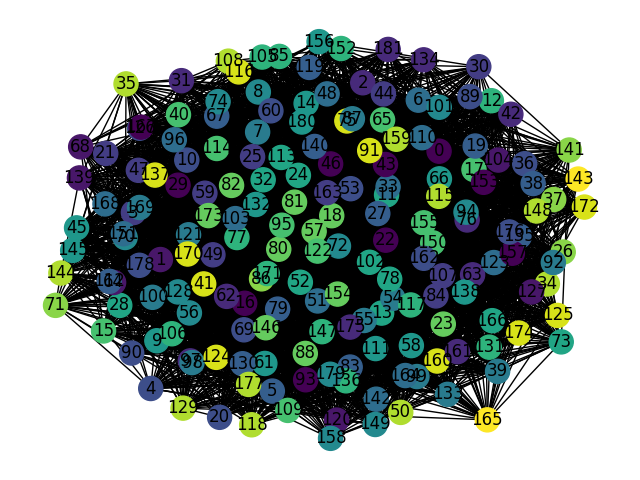

True


In [8]:
misc.draw(iterator.algo.G, iterator.algo.getColoring())
print(misc.verifyColoring(iterator.algo.G, iterator.algo.getColoring()))